In [105]:
import pandas as pd

# Load the dataset
file_path_1 = './open-meteo.csv'
file_path_2 = './data_NO2.csv'

# Read the datasets
weather_data = pd.read_csv(file_path_1)
energy_data = pd.read_csv(file_path_2)

# Display the first few rows of both datasets to understand their structure
weather_data_head = weather_data.head()
energy_data_head = energy_data.head()

weather_data_head, energy_data_head

(               time  temperature_2m (°C)  rain (mm)  cloud_cover (%)  \
 0  2015-12-31T00:00                  8.5        1.4              100   
 1  2015-12-31T01:00                  8.4        1.4              100   
 2  2015-12-31T02:00                  8.2        1.4              100   
 3  2015-12-31T03:00                  7.8        1.2              100   
 4  2015-12-31T04:00                  7.3        0.7              100   
 
    wind_speed_10m (m/s)  is_day ()  sunshine_duration (s)  
 0                 12.89          0                    0.0  
 1                 12.21          0                    0.0  
 2                 11.47          0                    0.0  
 3                 10.60          0                    0.0  
 4                 10.19          0                    0.0  ,
   datetime_utc;volume_demand;volume_production;spot_price
 0      2015-12-31 23:00:00+00:00;4043.0;7818.0;16.39     
 1      2016-01-01 00:00:00+00:00;4010.0;7694.0;16.04     
 2      2016-01-

In [106]:
# Split the energy data into separate columns
energy_data_split = energy_data['datetime_utc;volume_demand;volume_production;spot_price'].str.split(';', expand=True)
energy_data_split.columns = ['datetime_utc', 'volume_demand', 'volume_production', 'spot_price']

# Convert to appropriate data types
energy_data_split['datetime_utc'] = pd.to_datetime(energy_data_split['datetime_utc'])
energy_data_split['volume_demand'] = pd.to_numeric(energy_data_split['volume_demand'], errors='coerce')
energy_data_split['volume_production'] = pd.to_numeric(energy_data_split['volume_production'], errors='coerce')
energy_data_split['spot_price'] = pd.to_numeric(energy_data_split['spot_price'], errors='coerce')

# Clean the weather data by renaming columns and converting the time column
weather_data_cleaned = weather_data.rename(columns={'time': 'datetime_utc'})
weather_data_cleaned['datetime_utc'] = pd.to_datetime(weather_data_cleaned['datetime_utc'])

# Ensure both datetime columns are converted to the same format (UTC)
weather_data_cleaned['datetime_utc'] = pd.to_datetime(weather_data_cleaned['datetime_utc']).dt.tz_localize('UTC')
energy_data_split['datetime_utc'] = pd.to_datetime(energy_data_split['datetime_utc']).dt.tz_convert('UTC')

# Merge the datasets based on the datetime
merged_data = pd.merge(energy_data_split, weather_data_cleaned, on='datetime_utc', how='inner')

# Feature Engineering: Extracting time-based features from the datetime column
merged_data['hour'] = merged_data['datetime_utc'].dt.hour
merged_data['day'] = merged_data['datetime_utc'].dt.day
merged_data['month'] = merged_data['datetime_utc'].dt.month

# Creating lag features for spot price (lag of 24 hours)
merged_data['lag_spot_price_24hr'] = merged_data['spot_price'].shift(24)
merged_data['lag_spot_price_1hr'] = merged_data['spot_price'].shift(1)
merged_data['lag_spot_price_2hr'] = merged_data['spot_price'].shift(2)

# Removing rows with missing values (due to lag feature creation)
merged_data_clean = merged_data.dropna()

# Display the first few rows of the cleaned and merged dataset
merged_data_clean.head()

,datetime_utc,volume_demand,volume_production,spot_price,temperature_2m (°C),rain (mm),cloud_cover (%),wind_speed_10m (m/s),is_day (),sunshine_duration (s),hour,day,month,lag_spot_price_24hr,lag_spot_price_1hr,lag_spot_price_2hr
24,2016-01-01 23:00:00+00:00,4118.0,8121.0,16.47,2.3,0.0,31,3.95,0,0.0,23,1,1,16.39,16.25,16.75
25,2016-01-02 00:00:00+00:00,4004.0,7525.0,15.89,2.6,0.0,42,4.24,0,0.0,0,2,1,16.04,16.47,16.25
26,2016-01-02 01:00:00+00:00,3940.0,6347.0,15.03,3.7,0.0,67,5.15,0,0.0,1,2,1,15.74,15.89,16.47
27,2016-01-02 02:00:00+00:00,3900.0,5074.0,13.19,4.5,0.0,100,6.22,0,0.0,2,2,1,15.57,15.03,15.89
28,2016-01-02 03:00:00+00:00,3944.0,4564.0,12.69,5.1,0.0,100,6.67,0,0.0,3,2,1,15.47,13.19,15.03


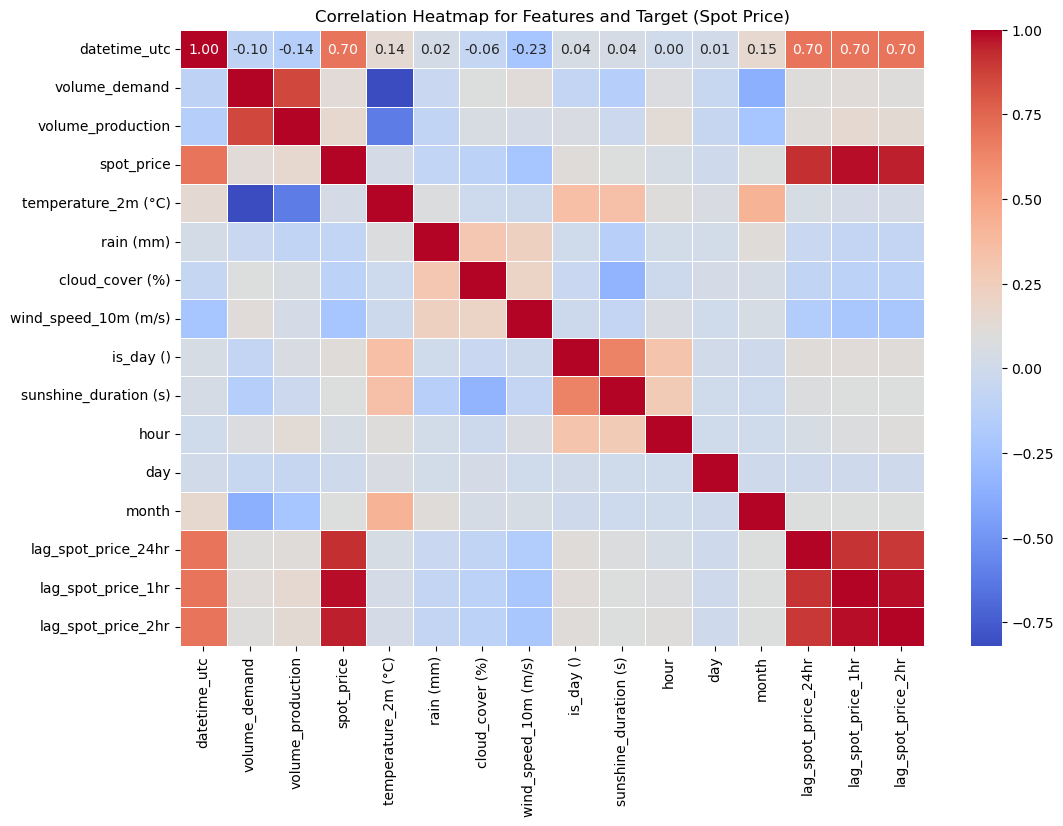

/opt/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


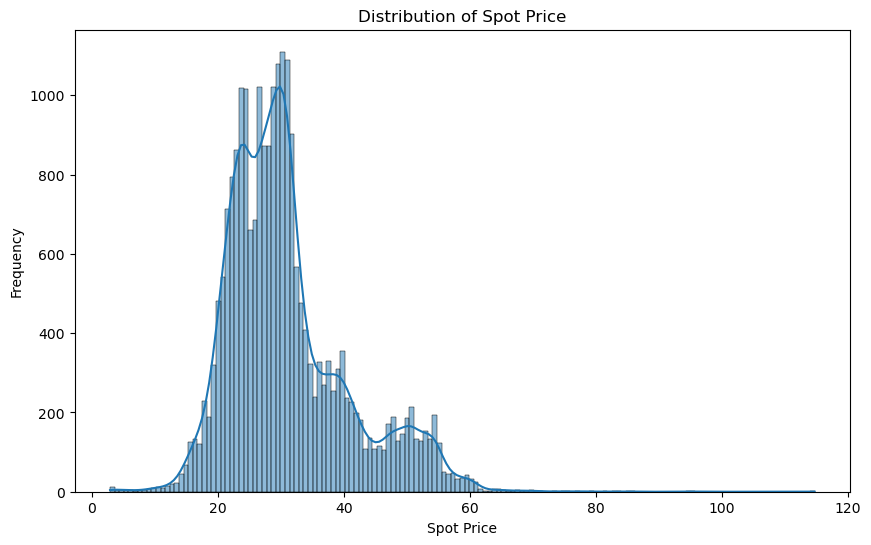

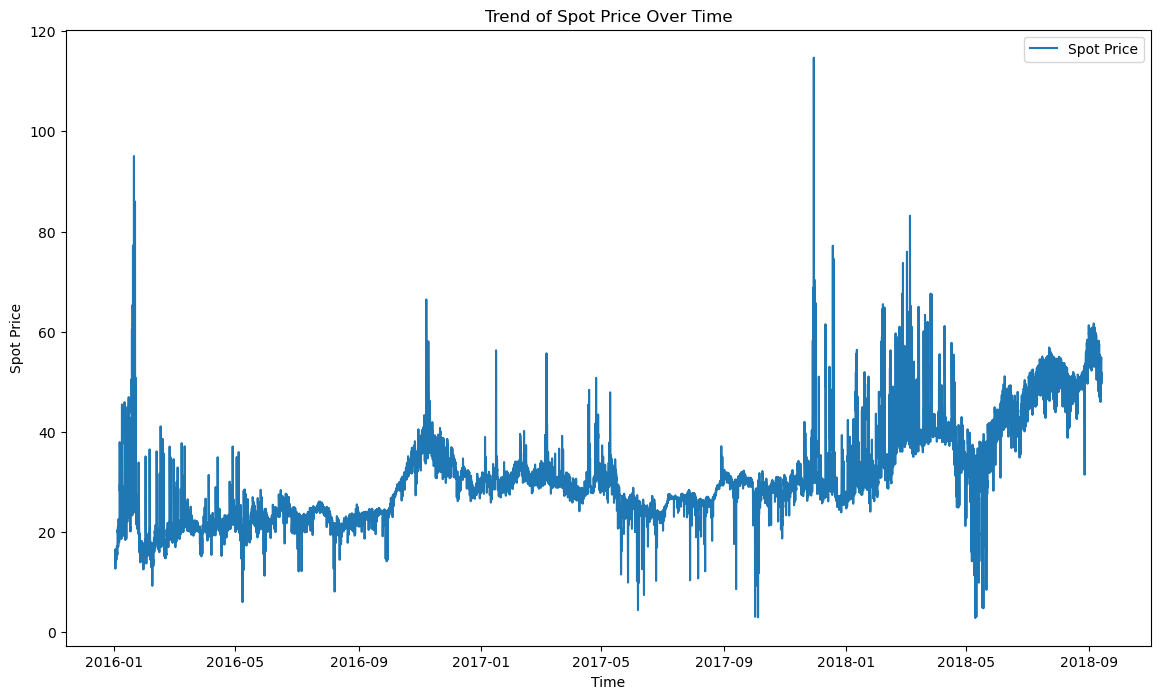

In [107]:
# Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix for the merged dataset
correlation_matrix = merged_data_clean.corr()

# Plotting the heatmap for correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap for Features and Target (Spot Price)")
plt.show()

# Plotting the distribution of spot price
plt.figure(figsize=(10, 6))
sns.histplot(merged_data_clean['spot_price'], kde=True)
plt.title("Distribution of Spot Price")
plt.xlabel("Spot Price")
plt.ylabel("Frequency")
plt.show()

# Visualizing the trend of spot price over time
plt.figure(figsize=(14, 8))
plt.plot(merged_data_clean['datetime_utc'], merged_data_clean['spot_price'], label='Spot Price')
plt.title("Trend of Spot Price Over Time")
plt.xlabel("Time")
plt.ylabel("Spot Price")
plt.legend()
plt.show()


In [108]:

# Now proceed to building a model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define features (excluding volume_demand, volume_production)
# features = ['temperature_2m (°C)', 'cloud_cover (%)', 'wind_speed_10m (m/s)', 'hour', 'day', 'month', 'lag_spot_price_24hr', 'rain (mm)']
features = ['temperature_2m (°C)', 'sunshine_duration (s)', 'is_day ()', 'hour', 'month', 'lag_spot_price_24hr']
target = 'spot_price'

# Time series split by chronological order
cutoff_date = '2018-04-05'
train_data = merged_data_clean[merged_data_clean['datetime_utc'] < cutoff_date]
test_data = merged_data_clean[merged_data_clean['datetime_utc'] >= cutoff_date]

print(train_data.shape)
print(test_data.shape)

# Define features and target again
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# Initialize and train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
print(y_pred.shape)

# Calculate the mean squared error (MSE)
mse_time_series = mean_squared_error(y_test, y_pred)

# Displaying the model's performance
mse_time_series, y_pred[:5], y_test[:5].values


(19775, 16)
(3867, 16)
(3867,)


(112.0315535814934,
 array([39.3796, 38.9378, 38.0181, 39.81  , 38.8615]),
 array([38.8 , 39.09, 38.96, 40.23, 42.24]))

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Initialize a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Reduced parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=20, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error', random_state=42)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Best parameters and model evaluation
best_params = random_search.best_params_
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)
best_rf_pred = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, best_rf_pred)

mse_best_rf, best_params



Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time

(113.12409169582475,
 {'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_depth': 10,
  'bootstrap': True})

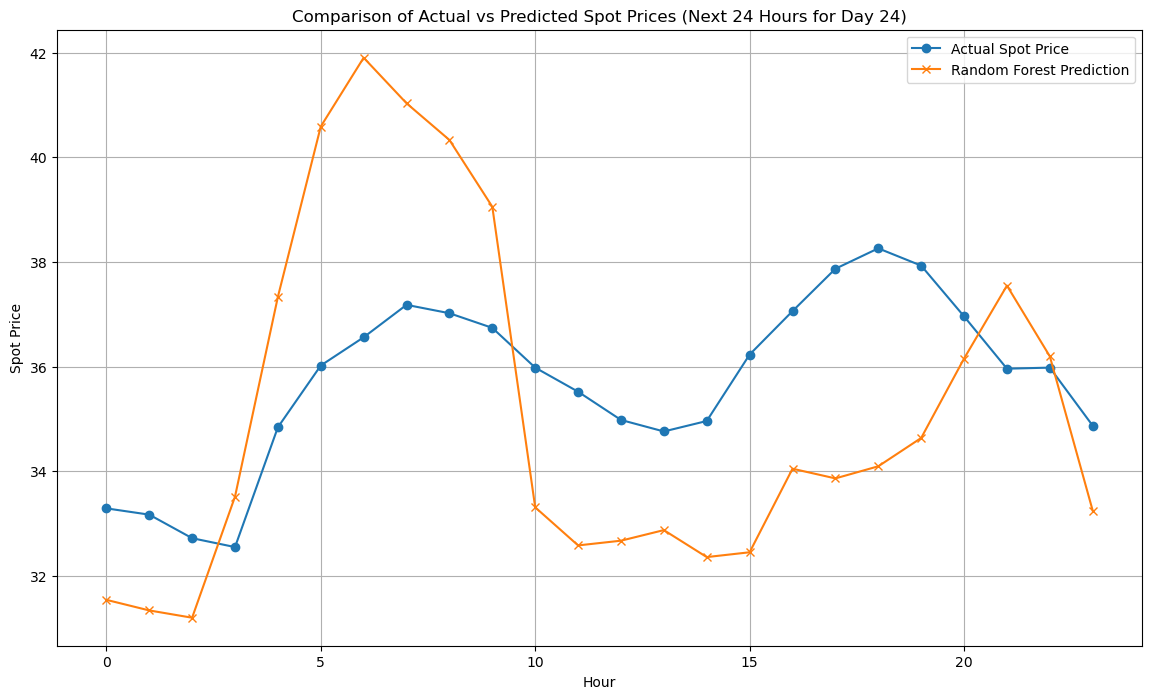

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a specific day from the test set (e.g., day 17)
day = np.random.randint(1, 100)
chosen_day_start = (24 * (day - 1))  # Start index for the chosen day
chosen_day_end = (24 * day)  # End index for the chosen day

# Get the test data for the chosen day
chosen_day = test_data.iloc[chosen_day_start:chosen_day_end]

# Get features for the chosen day to predict the next 24 hours using the fine-tuned Random Forest model
X_chosen_day = chosen_day[features]

# Predict the next 24 hours using the best Random Forest model
rf_pred_next_24 = best_rf_model.predict(X_chosen_day)

# Actual spot prices for the next 24 hours for the same day
actual_next_24 = chosen_day['spot_price'].values

# Plot the comparison of predictions and actual values
plt.figure(figsize=(14, 8))

# Plot actual spot prices
plt.plot(range(24), actual_next_24, label='Actual Spot Price', marker='o')

# Plot Random Forest predictions
plt.plot(range(24), rf_pred_next_24, label='Random Forest Prediction', marker='x')

# Add labels and title
plt.title(f"Comparison of Actual vs Predicted Spot Prices (Next 24 Hours for Day {day})")
plt.xlabel("Hour")
plt.ylabel("Spot Price")
plt.legend()
plt.grid(True)
plt.show()


## AutoML

In [ ]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

# Initialize H2O
h2o.init()

# Convert pandas DataFrames to H2O Frames
h2o_train = h2o.H2OFrame(train_data)
h2o_test = h2o.H2OFrame(test_data)

# Define target and features
target = 'spot_price'
features = features

# Run H2O AutoML
aml = H2OAutoML(max_runtime_secs=600, seed=42, nfolds=5)  # adjust max_runtime_secs as needed
aml.train(x=features, y=target, training_frame=h2o_train)

# Get the best model from the AutoML leaderboard
best_model = aml.leader

# Make predictions on the test set
preds = best_model.predict(h2o_test[features])

# Convert H2O predictions back to pandas for comparison
rf_pred_next_24 = preds.as_data_frame().values.flatten()
actual_next_24 = test_data[target].values

# Plot the results similar to the previous approach
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(range(24), actual_next_24[:24], label='Actual Spot Price', marker='o')
plt.plot(range(24), rf_pred_next_24[:24], label='H2O AutoML Prediction', marker='x')
plt.title("Comparison of Actual vs H2O AutoML Predicted Spot Prices (Next 24 Hours)")
plt.xlabel("Hour")
plt.ylabel("Spot Price")
plt.legend()
plt.grid(True)
plt.show()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 days 19 hours 33 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_andreasolborg_qhqnty
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.637 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
10:50:54.240: AutoML: XGBoost is not available; skipping it.

█████████████████████

## XGBOOST

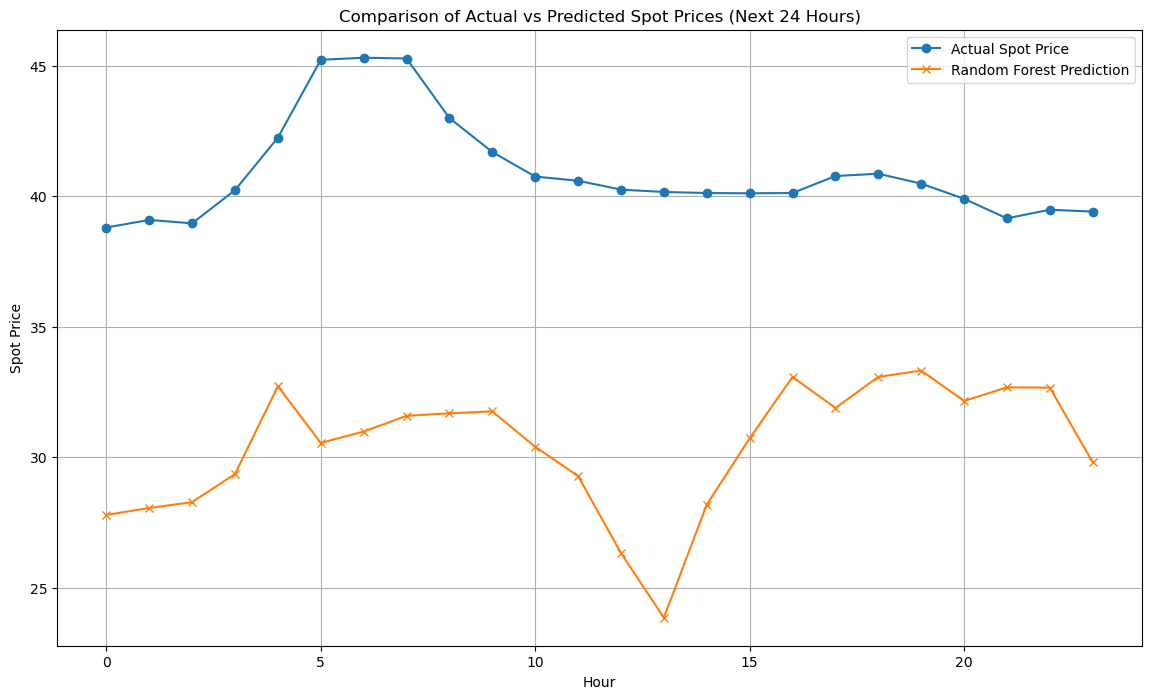

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Prepare the training and testing data for XGBoost
X_train_xgb = X_train[features]
y_train_xgb = y_train
X_test_xgb = X_test[features]
y_test_xgb = y_test

# Define the XGBoost model with hyperparameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    colsample_bytree=0.3,
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
    n_estimators=200
)

# Train the model
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict the next 24 hours using XGBoost
xgb_pred_next_24 = xgb_model.predict(X_test_xgb)

# Calculate mean squared error for XGBoost model
mse_xgb = mean_squared_error(y_test_xgb, xgb_pred_next_24)
print(f"Mean Squared Error for XGBoost: {mse_xgb}")

# Visualization of predictions
plt.figure(figsize=(14, 8))
plt.plot(range(24), y_test_xgb[:24], label='Actual Spot Price', marker='o')
plt.plot(range(24), xgb_pred_next_24[:24], label='XGBoost Prediction', marker='x')
plt.title("Comparison of Actual vs XGBoost Predicted Spot Prices (Next 24 Hours)")
plt.xlabel("Hour")
plt.ylabel("Spot Price")
plt.legend()
plt.grid(True)
plt.show()
